$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

This notebook will provide an introduction to implementing variational quantum eigensolver (<b>VQE</b>) using pyQuil. VQE relies on the variational principle, which states that for a any Hamiltonian $\hat{H}$ and any arbitrary state $\ket{\psi}$, the expectation value $\bra{\psi}\hat{H}\ket{\psi}$ is always greater than the ground state energy of $\hat{H}$. By assuming an ansatz for $\ket{\psi}$ and parametrizing it with a unitary; $\ket{\psi} = \hat{U}(\vec{\theta})\ket{0}$, one can search through the parameter space of $\vec{\theta}$ to look for a state that is closest in energy to the ground state. Some applications of VQE includes finding the ground state in an electronic structure calculation or to search for the solution to a minimization problem that is mapped onto a Hamiltonian.

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

The VQE algorithm includes three steps. Start with an initial guess for $\vec{\theta}$:

(1) Prepare the ansatz
<br>
(2) Measure the expectation $\bra{\psi}\hat{H}\ket{\psi}$
<br>
(3) Feed the expectation values into an optimizer to obtain a new guess for $\vec{\theta}$ and repeat the steps until some convergence criterion is satisfied.

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

We illustrate this problem with a simple example. Consider a Hamiltonian given by $\hat{H} = \hat{Z}$. We know the ground state of this is $\ket{1}$ with an energy of -1.0 . We used an ansatz given by
<br>
$$\ket{\psi(\theta)} = R_{x}(\theta)\ket{0}$$

This can be defined in the following python code

In [1]:
from pyquil import Program, get_qc
from pyquil.gates import *
%matplotlib inline

def ansatz(theta):
    return Program(RX(theta[0],0))



We can construct an objective function that returns the expectation value of the Hamiltonian given $\theta$

In [2]:
from pyquil.noise import estimate_bitstring_probs

def obj(x):
    p = ansatz(x)
    p.wrap_in_numshots_loop(10000)
    ro = p.declare('ro','BIT',1)
    p += MEASURE(0,ro[0])
    qc = get_qc('1q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy = probs[0] - probs[1]
    return energy

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

The final step is to construct an optimizer that provides a new $\theta$ given return from the objective function. Let us try the Nelder-Mead method. In the homework set, you will compare the performance of Nelder-Mead and Powell.

What is happening here is we initialize $\theta$ as 0.28 . We then use the minimizer provided by scipy to perform optimization. Note that this part of the code will take 20 to 30 seconds to run.

In [3]:
from scipy.optimize import minimize
import numpy as np

def vqe():
    theta0 = np.array([0.28])
    res = minimize(obj,x0=theta0,method='Nelder-Mead', options={'maxiter': 100, 'disp': True})
    return res
final_result = vqe()
print(final_result)

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 22
         Function evaluations: 52
 final_simplex: (array([[3.15      ],
       [3.14994531]]), array([-1., -1.]))
           fun: -1.0
       message: 'Optimization terminated successfully.'
          nfev: 52
           nit: 22
        status: 0
       success: True
             x: array([3.15])


$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

Visualizing trajectories generated during optimization allows one to assess the performance of an optimizer. We can visualize the trajectories generated in the following way:


Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 23
         Function evaluations: 55


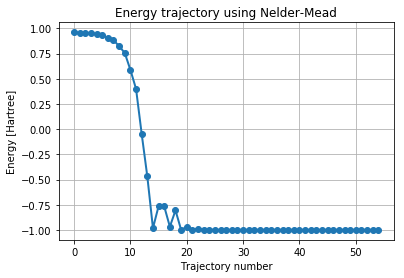

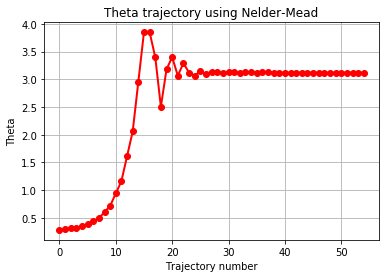

In [4]:
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.noise import estimate_bitstring_probs
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt


def ansatz(theta):
    return Program(RX(theta[0],0))

energy_traj = []
theta_traj = []

def obj(x):
    p = ansatz(x)
    p.wrap_in_numshots_loop(20000)
    ro = p.declare('ro','BIT',1)
    p += MEASURE(0,ro[0])
    qc = get_qc('1q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy = probs[0] - probs[1]
    energy_traj.append(energy)
    theta_traj.append(x[0])
    return energy

def vqe():
    theta0 = np.array([0.28])
    res = minimize(obj,x0=theta0,method='Nelder-Mead', options={'maxiter': 100, 'disp': True})
    return res

final_result = vqe()

plt.figure()
plt.plot(energy_traj, "-o", linewidth=2)
plt.grid()
plt.title("Energy trajectory using Nelder-Mead")
plt.xlabel("Trajectory number")
plt.ylabel("Energy [Hartree]")
plt.figure()
plt.plot(theta_traj, "-ro", linewidth=2)
plt.grid()
plt.title("Theta trajectory using Nelder-Mead")
plt.xlabel("Trajectory number")
plt.ylabel("Theta")
plt.show()

We can see that the optimizer managed to reach the ground state after some time. As you can imagine, the performance of VQE is heavily dependent on the optimizers used and there is active research going on to address these issues. Recent studies includes [(i)assessing the performance of different optimizers](https://meetings.aps.org/Meeting/MAR19/Session/F27.10)  and (ii) [coming out with new optimization strategies](https://arxiv.org/abs/1904.03206). Some of you might be interested in pursuing this research direction to make VQE perform better.

There are times when VQE fails. One example is this: Suppose we start at $\theta$ = 0.1 . The algorithm fails to find the ground state.

Optimization terminated successfully.
         Current function value: 0.992600
         Iterations: 19
         Function evaluations: 50


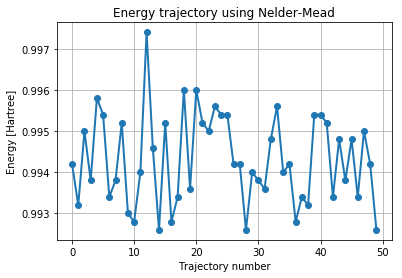

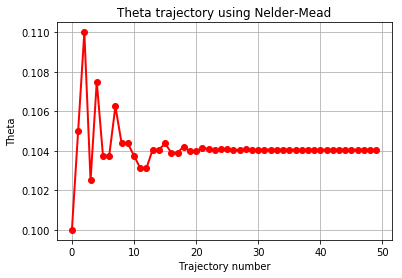

In [5]:
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.noise import estimate_bitstring_probs
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt


def ansatz(theta):
    return Program(RX(theta[0],0))

energy_traj = []
theta_traj = []

def obj(x):
    p = ansatz(x)
    p.wrap_in_numshots_loop(10000)
    ro = p.declare('ro','BIT',1)
    p += MEASURE(0,ro[0])
    qc = get_qc('1q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy = probs[0] - probs[1]
    energy_traj.append(energy)
    theta_traj.append(x[0])
    return energy

def vqe():
    theta0 = np.array([0.1])
    res = minimize(obj,x0=theta0,method='Nelder-Mead', options={'maxiter': 100, 'disp': True})
    return res

final_result = vqe()

plt.figure()
plt.plot(energy_traj, "-o", linewidth=2)
plt.grid()
plt.title("Energy trajectory using Nelder-Mead")
plt.xlabel("Trajectory number")
plt.ylabel("Energy [Hartree]")
plt.figure()
plt.plot(theta_traj, "-ro", linewidth=2)
plt.grid()
plt.title("Theta trajectory using Nelder-Mead")
plt.xlabel("Trajectory number")
plt.ylabel("Theta")
plt.show()

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

So what is happening? Let's us try to compare the two graphs; For a given $\theta$, we want to compute (a) the exact value of $\bra{\psi(\theta)}\hat{H}\ket{\psi(\theta)}$ and (b) the expectation value obtained using sampling with a quantum computer.

/Users/atanteck/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


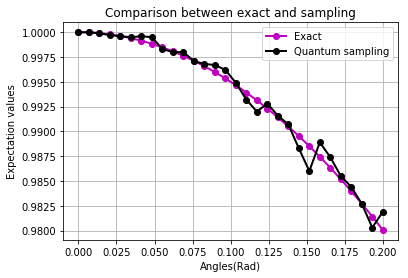

In [6]:
import numpy as np
import matplotlib.pyplot as plt

angles = np.linspace(0,0.2,30)

# Exact solution using classical means
energy_exact = []
# Construct computational basis
vect = np.zeros([2],dtype=complex)
vect[0] = 1

# Function to create RX_gate
def RX_gate(angle):
    Rxgate = np.zeros([2,2],dtype=complex)
    Rxgate[0,0] = np.cos(angle / 2)
    Rxgate[0,1] = -1j*np.sin(angle / 2)
    Rxgate[1,0] = 1j*np.sin(angle / 2)
    Rxgate[1,1] = np.cos(angle / 2)
    return Rxgate

# Construct Hamiltonian Sz
Sz = np.zeros([2,2],dtype=complex)
Sz[0,0] = 1.0
Sz[1,1] = -1.0

classical_expectation = []
for theta in angles:
    Rxgate = RX_gate(theta)
    vect_ansatz = np.matmul(Rxgate,vect)
    expectation = np.matmul(Sz,vect_ansatz)
    expectation = np.matmul(np.conj(np.transpose(vect_ansatz)),expectation)
    classical_expectation.append(expectation)

# Values obtained by sampling using quantum computers
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.noise import estimate_bitstring_probs

def ansatz(theta):
    return Program(RX(theta[0],0))

def obj(x):
    p = ansatz(x)
    p.wrap_in_numshots_loop(20000)
    ro = p.declare('ro','BIT',1)
    p += MEASURE(0,ro[0])
    qc = get_qc('1q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy = probs[0] - probs[1]
    energy_traj.append(energy)
    theta_traj.append(x[0])
    return energy

quantum_expectation = []
for theta in angles:
    quantum_expectation.append(obj([theta]))

plt.figure()
plt.plot(angles,classical_expectation, "-mo", label='Exact',linewidth=2)
plt.plot(angles,quantum_expectation,"-ko", label='Quantum sampling', linewidth=2)
plt.grid()
plt.legend()
plt.title("Comparison between exact and sampling")
plt.xlabel("Angles(Rad)")
plt.ylabel("Expectation values")
plt.show()

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

From the graph, we can tell that the values obtained using the emulator has some noise associated with and this is the source of our problem: The statistical noise that comes from sampling can affect the performance of VQE dramatically. Of course, we can always increase the sample size to reduce the statistical noise which hopefully improves the performance of the optimizers. Let's increase the number of shots from 10,000 to 200,000 for our vqe calculations and see what happens. Note this part of the calculation will take around a few minutes.

Optimization terminated successfully.
         Current function value: -1.000000
         Iterations: 23
         Function evaluations: 51


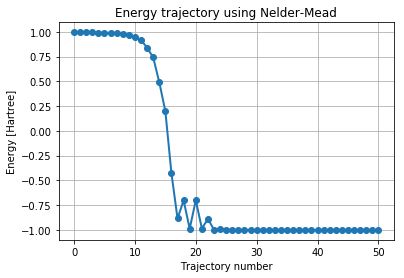

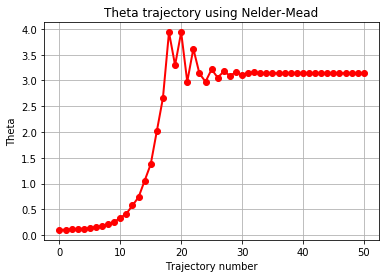

In [7]:
from pyquil import Program, get_qc
from pyquil.gates import *
from pyquil.noise import estimate_bitstring_probs
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt


def ansatz(theta):
    return Program(RX(theta[0],0))

energy_traj = []
theta_traj = []

def obj(x):
    p = ansatz(x)
    p.wrap_in_numshots_loop(200000)
    ro = p.declare('ro','BIT',1)
    p += MEASURE(0,ro[0])
    qc = get_qc('1q-qvm')
    exe = qc.compile(p)
    result = qc.run(exe)
    probs = estimate_bitstring_probs(result)
    energy = probs[0] - probs[1]
    energy_traj.append(energy)
    theta_traj.append(x[0])
    return energy

def vqe():
    theta0 = np.array([0.1])
    res = minimize(obj,x0=theta0,method='Nelder-Mead', options={'maxiter': 100, 'disp': True})
    return res

final_result = vqe()

plt.figure()
plt.plot(energy_traj, "-o", linewidth=2)
plt.grid()
plt.title("Energy trajectory using Nelder-Mead")
plt.xlabel("Trajectory number")
plt.ylabel("Energy [Hartree]")
plt.figure()
plt.plot(theta_traj, "-ro", linewidth=2)
plt.grid()
plt.title("Theta trajectory using Nelder-Mead")
plt.xlabel("Trajectory number")
plt.ylabel("Theta")
plt.show()

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

Success! But you can see an issue here, noise can affect the performance of VQE dramatically. Other than statistical noise, other sources of errors are present in your quantum device. You can imagine that when there are more optimization parameters in your ansatz, the performance of VQE is going to take a beating. To utilize near-term quantum devices, one needs to think of strategies to perform calculations in such a noisy environment. In the context of VQE, [one approach is to use more noise resilient optimizers such as a particle swarm optimizer](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.011021). How about noise from statistical sampling? [One can try to adopt some form of importance sampling to reduce the variance in the measurements.](https://iopscience.iop.org/article/10.1088/1367-2630/aab919/meta) For those who are interested in research involving applications of near-term quantum devices, these might be directions you wish to look at.